In [33]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed, BatchNormalization
import numpy as np
import h5py
import matplotlib.pyplot as plt
from data_utils import get_data
from sklearn import preprocessing


In [2]:
# Load data from all .mat files, combine them, eliminate EOG signals, shuffle and 
# seperate training data, validation data and testing data.
# Also do mean subtraction on x.

data = get_data('project_datasets',num_validation=50, num_test=0, subtract_mean=True, subtract_axis=1,
                transpose=True)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))

X_train: (2508, 1000, 22) 
y_train: (2508,) 
X_val: (50, 1000, 22) 
y_val: (50,) 
X_test: (0, 1000, 22) 
y_test: (0,) 


In [60]:
# substract data from list
X_train = data.get('X_train')
y_train = data.get('y_train')
X_val = data.get('X_val')
y_val = data.get('y_val')
#X_test = data.get('X_test')
#y_test = data.get('y_test')

# get data dimension
N_train, T_train, C_train = data.get('X_train').shape
N_val, T_val, C_val = data.get('X_val').shape
#N_test, T_test, C_test = data.get('X_test').shape

# add dummy zeros for y classification
lb = preprocessing.LabelBinarizer()
lb.fit([0, 1, 2, 3,])
lb.classes_
y_train = lb.transform(y_train)
y_val = lb.transform(y_val)
#y_test = lb.transform(y_test)

In [61]:
# # normalize data across the time sequence dimension only
# scaler = preprocessing.MinMaxScaler()
# for i in range(N_train):
#     scaler.fit(X_train[i,:,:])
#     X_train[i,:,:] = scaler.transform(X_train[i,:,:])
    
# for i in range(N_val):
#     scaler.fit(X_val[i,:,:])
#     X_val[i,:,:] = scaler.transform(X_val[i,:,:])

In [62]:
# construct X_total and y_total based on sub-sampling of X_train and y_train

# take sub-sampling on the time sequence to reduce dimension for RNN
sampling = 4

X_train = X_train.reshape(N_train,int(T_train/sampling), sampling, C_train)[:,:,0,:]
X_val = X_val.reshape(N_val,int(T_val/sampling), sampling, C_val)[:,:,0,:]
    
# get new data dimension
N_train, T_train, C_train = X_train.shape
N_val, T_val, C_val = X_val.shape

print('X_train: ', X_train.shape)
print('X_val: ', X_val.shape)

X_train:  (2508, 250, 22)
X_val:  (50, 250, 22)


In [68]:
# Expected input batch shape: (batch_size, timesteps, data_dim)
# Note that we have to provide the full batch_input_shape since the network is stateful.
# the sample of index i in batch k is the follow-up for the sample i in batch k-1.

# perhaps should try masking layer

data_dim = C_train
timesteps = T_train
num_classes = 4
batch_size = 50
num_epoch = 30

model = Sequential()
model.add(LSTM(40, return_sequences=True, stateful=False,
          batch_input_shape=(batch_size, timesteps, data_dim)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(LSTM(40, return_sequences=True, stateful=False))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(LSTM(40, stateful=False))
model.add(Dropout(0.5))
# model.add(TimeDistributed(Dense(T_train)))
model.add(Dense(50,activation='softmax'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [69]:
# train the data with validation
history = model.fit(X_train[0:int(N_train/batch_size)*batch_size, :, :],
                    y_train[0:int(N_train/batch_size)*batch_size, :],
                    batch_size=batch_size, epochs=num_epoch, shuffle=False,
                    validation_data=(X_val, y_val))

Train on 2500 samples, validate on 50 samples
Epoch 1/30
2500/2500 [==============================] - 20s 8ms/step - loss: 1.3863 - acc: 0.2576 - val_loss: 1.3869 - val_acc: 0.2000
Epoch 2/30
2500/2500 [==============================] - 16s 6ms/step - loss: 1.3856 - acc: 0.2528 - val_loss: 1.3884 - val_acc: 0.1800
Epoch 3/30
2500/2500 [==============================] - 16s 7ms/step - loss: 1.3845 - acc: 0.2848 - val_loss: 1.3875 - val_acc: 0.2200
Epoch 4/30
2500/2500 [==============================] - 16s 6ms/step - loss: 1.3815 - acc: 0.3092 - val_loss: 1.3876 - val_acc: 0.2600
Epoch 5/30
2500/2500 [==============================] - 16s 7ms/step - loss: 1.3782 - acc: 0.3064 - val_loss: 1.3881 - val_acc: 0.2600
Epoch 6/30
2500/2500 [==============================] - 16s 6ms/step - loss: 1.3727 - acc: 0.3212 - val_loss: 1.3871 - val_acc: 0.3200
Epoch 7/30
2500/2500 [==============================] - 19s 7ms/step - loss: 1.3672 - acc: 0.3360 - val_loss: 1.3878 - val_acc: 0.2400
Epoch 8/3

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


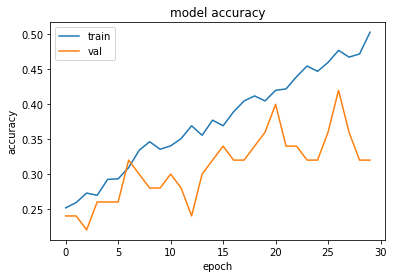

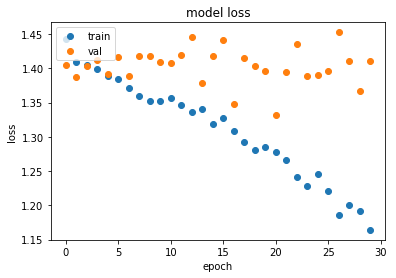

In [40]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'],'o')
plt.plot(history.history['val_loss'],'o')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()